In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl

import am_sim as ams

### Load parameters and dataset

In [2]:
# load search df
df = pd.read_csv('inference_results/t_final_search_history.csv', index_col=0)

# load best parameters set from search dataframe
from utilities.analyze_inference import best_par_in_df
par = best_par_in_df(df)

# load dataset
from utilities.dataset_interface import load_all_datasets
dsets = load_all_datasets()

### Deterministic model simulation

In [3]:
# simulate each scheme with the deterministic model
det_rps = []
for ds in dsets:
    det_rp = ams.responders_from_dset(ds, par, sim_type='deterministic')
    det_rps.append(det_rp)
det_rps = np.array(det_rps)

### Figure 6 - main text version

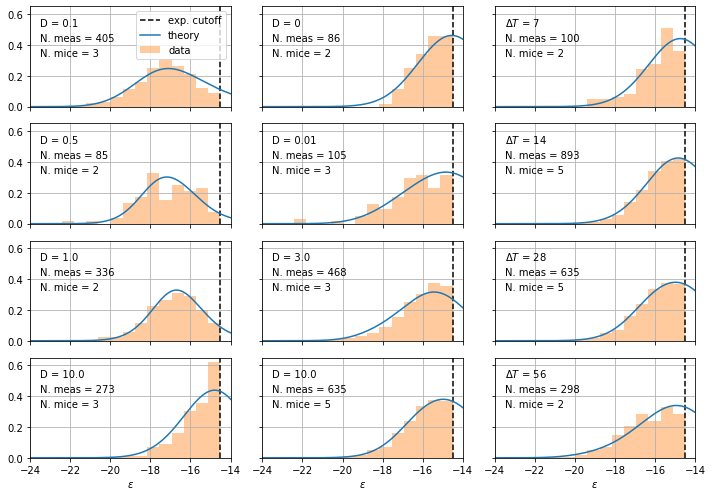

In [6]:
from am_sim.model_parameters import high_en_exp_cutoff, low_en_exp_cutoff
from utilities.dataset_interface import extract_scheme_info
from utilities.plot_dataset import plot_dset_hist
from utilities.plot_det_pop import plot_exp_normalized_pop

# dosages to plot for the first scheme
plot_D_1 = [0.1, 0.5, 1., 10.]
# dosage to plot for the second scheme
plot_D_2 = [0., 0.01, 3., 10.]
# time delays to plot for the third scheme
plot_T_3 = [7, 14, 28, 56]


# define bins for dataset histogram
dset_bins = np.linspace(low_en_exp_cutoff,high_en_exp_cutoff,15)

# define plot function for every subfigure
def draw_subplot(ax, ds, det_pf):
    # plot experimental cutoff line
    ax.axvline(high_en_exp_cutoff, ls='--', c='k', label='exp. cutoff')
    # plot experimental measurements
    plot_dset_hist(ax, ds, dset_bins)
    # plot deterministic model prediction
    plot_exp_normalized_pop(ax, det_pf)
    # print the number of measurements per scheme
    ax.text(0.05, 0.65, f'N. meas = {ds.all_en().size}', transform=ax.transAxes)
    ax.text(0.05, 0.50, f'N. mice = {len(ds.en)}', transform=ax.transAxes)
    # activate the grid
    ax.grid(True)
    
# setup figure
fig, ax = plt.subplots(4,3,figsize=(10,7), sharex=True, sharey=True)


# extract the list of attributes of the immunization schemes
mp_ds, D_ds, T_ds = extract_scheme_info(dsets)

# plot scheme 1
for n_ax, D in enumerate(plot_D_1):
    # mask to select the correct dataset
    mask = (mp_ds == '4d') & (T_ds == 28) & (D_ds == D)
    # select the correct dataset and corresponding deterministic simulation
    ds = dsets[mask][0]
    det_pf = det_rps[mask][0]
    
    # plot the data histogram and the normalized distribution
    draw_subplot(ax[n_ax,0], ds, det_pf)
    
    # specify the Ag dosage
    ax[n_ax,0].text(0.05, 0.8, f'D = {ds.D_inj[0]}', transform=ax[n_ax,0].transAxes)
    
# plot scheme 2
for n_ax, D in enumerate(plot_D_2):
    # mask to select the correct dataset
    mask = (mp_ds == '1d') & (T_ds == 28) & (D_ds == D)
    # select the correct dataset and corresponding deterministic simulation
    ds = dsets[mask][0]
    det_pf = det_rps[mask][0]
    
    # plot the data histogram and the normalized distribution
    draw_subplot(ax[n_ax,1], ds, det_pf)
    
    # specify the Ag dosage
    ax[n_ax,1].text(0.05, 0.8, f'D = {ds.D_inj[0]}', transform=ax[n_ax,1].transAxes)
    
# plot scheme 3
for n_ax, T in enumerate(plot_T_3):
    # mask to select the correct dataset
    mask = (mp_ds == '1d') & (T_ds == T) & (D_ds == 10)
    # select the correct dataset and corresponding deterministic simulation
    ds = dsets[mask][0]
    det_pf = det_rps[mask][0]
    
    # plot the data histogram and the normalized distribution
    draw_subplot(ax[n_ax,2], ds, det_pf)
    
    # specify the injection time delay
    ax[n_ax,2].text(0.05, 0.8, r'$\Delta T$' + f' = {ds.T_delay[0]}', transform=ax[n_ax,2].transAxes)
    

# final figure setup
ax[0,0].legend(loc='upper right')
ax[0,0].set_xlim(-24, -14)
for i in range(3):
    ax[-1,i].set_xlabel(r'$\epsilon$')

plt.tight_layout()
plt.savefig('figures/fig_5/fig_5.pdf')
plt.show()


### Stochastic model simulations

In [7]:
np.random.seed(1) # for precise reproducibility, even though the average results do not depend strongly on the seed used

# NB: in case the simulation is too long one can simply load the results from the next cell

N_sims = 1000 # number of stochastic simulation trials per simulation-point

# perform N_sims stochastic simulations per dataset
stoch_rps = []
for n_ds, ds in enumerate(dsets):
    print(f'performing {N_sims} stochastic simulations for dataset n. {n_ds + 1} / {len(dsets)} ')
    stoch_rps.append([ams.responders_from_dset(ds, par, sim_type='stochastic') for n_sim in range(N_sims)])
stoch_rps = np.array(stoch_rps)
    
# save the results in a pickle file
with open('figures/fig_5/stoch_sim_results.pkl', 'wb') as f:
    pkl.dump(stoch_rps, f)
    f.close()

performing 1000 stochastic simulations for dataset n. 1 / 15 


KeyboardInterrupt: 

In [ ]:
# one can avoid running the stochastic simulations and simply loading the results here
with open('figures/fig_5/stoch_sim_results.pkl', 'rb') as f:
    stoch_rps = pkl.load(f)
    f.close()

### Figure 6 - SI full version

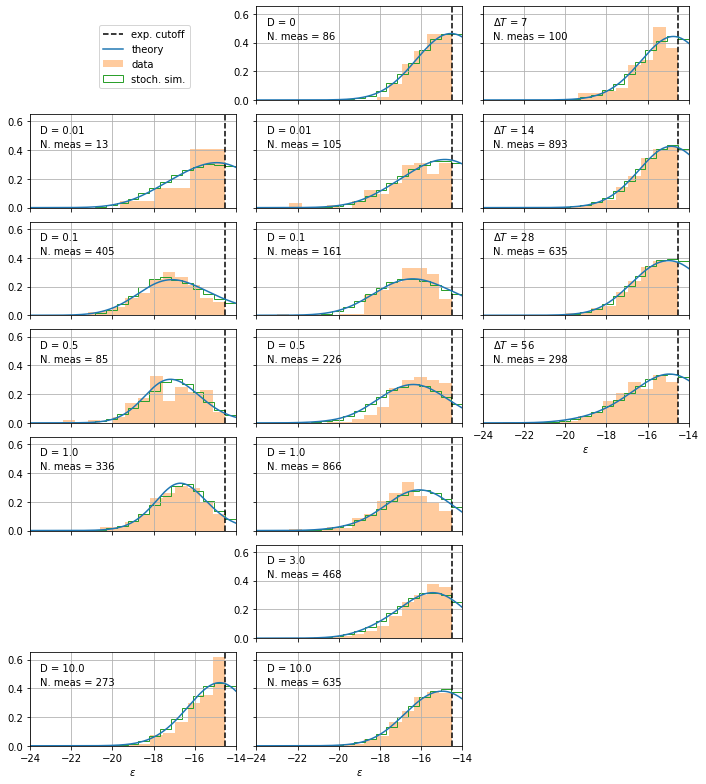

In [49]:
from am_sim.model_parameters import high_en_exp_cutoff, low_en_exp_cutoff
from utilities.dataset_interface import extract_scheme_info
from utilities.plot_dataset import plot_dset_hist
from utilities.plot_det_pop import plot_exp_normalized_pop
from utilities.plot_stoch_pop import plot_stoch_avg_energy_distr_exp_norm

# extract the list of attributes of the immunization schemes
mp_ds, D_ds, T_ds = extract_scheme_info(dsets)
# extract the sorted list of all possible dosages and 
D_list = np.sort(np.unique(D_ds))
T_list = np.sort(np.unique(T_ds))

# define bins for dataset histogram and for stoch_sim histogram
dset_bins = np.linspace(low_en_exp_cutoff,high_en_exp_cutoff,15)
stoch_bins = np.linspace(-24, -14, 20)

# define plot function for every subfigure
def draw_subplot(ax, ds, det_pf, stoch_pfs):
    # change binning for first scheme: there are only 13 measurements.
    if ds.meas_prot == '4d' and ds.D_inj[0] == 0.01:
        ds_bins = np.linspace(low_en_exp_cutoff,high_en_exp_cutoff,6)
    else:
        ds_bins = dset_bins
    # plot experimental cutoff line
    ax.axvline(high_en_exp_cutoff, ls='--', c='k', label='exp. cutoff')
    # plot experimental measurements
    plot_dset_hist(ax, ds, ds_bins)
    # plot average stochastic distribution
    plot_stoch_avg_energy_distr_exp_norm(ax, stoch_pfs, stoch_bins)
    # plot deterministic model prediction
    plot_exp_normalized_pop(ax, det_pf)
    # print the number of measurements per scheme
    ax.text(0.05, 0.65, f'N. meas = {ds.all_en().size}', transform=ax.transAxes)
    ax.grid(True)
    
# setup figure
fig, ax = plt.subplots(7,3,figsize=(10,11), sharex=True, sharey=True)

# plot scheme 1
for n_ax, D in enumerate(D_list):
    # mask to select the correct dataset
    mask = (mp_ds == '4d') & (T_ds == 28) & (D_ds == D)
    # if such a scheme has been tested, then plot it:
    if mask.sum() > 0:
        # select the correct dataset, corresponding deterministic and stochastic simulation
        ds = dsets[mask][0]
        det_pf = det_rps[mask][0]
        stoch_pfs = stoch_rps[mask][0]
        
        # plot the data histogram and the normalized distribution
        draw_subplot(ax[n_ax,0], ds, det_pf, stoch_pfs)

        # specify the Ag dosage
        ax[n_ax,0].text(0.05, 0.8, f'D = {ds.D_inj[0]}', transform=ax[n_ax,0].transAxes)
    else:
        # otherwise remove the plot
        ax[n_ax, 0].remove()
        
# plot scheme 2
for n_ax, D in enumerate(D_list):
    # mask to select the correct dataset
    mask = (mp_ds == '1d') & (T_ds == 28) & (D_ds == D)
    # select the correct dataset, corresponding deterministic and stochastic simulation
    ds = dsets[mask][0]
    det_pf = det_rps[mask][0]
    stoch_pfs = stoch_rps[mask][0]
    
    # plot the data histogram and the normalized distribution
    draw_subplot(ax[n_ax,1], ds, det_pf, stoch_pfs)
    
    # specify the Ag dosage
    ax[n_ax,1].text(0.05, 0.8, f'D = {ds.D_inj[0]}', transform=ax[n_ax,1].transAxes)
    
# plot scheme 3
for n_ax, T in enumerate(plot_T_3):
    # mask to select the correct dataset
    mask = (mp_ds == '1d') & (T_ds == T) & (D_ds == 10)
    # select the correct dataset, corresponding deterministic and stochastic simulation
    ds = dsets[mask][0]
    det_pf = det_rps[mask][0]
    stoch_pfs = stoch_rps[mask][0]
    
    # plot the data histogram and the normalized distribution
    draw_subplot(ax[n_ax,2], ds, det_pf, stoch_pfs)
    
    # specify the injection time delay
    ax[n_ax,2].text(0.05, 0.8, r'$\Delta T$' + f' = {ds.T_delay[0]}', transform=ax[n_ax,2].transAxes)
    
# remove extra plots for scheme 3
for n_ax in range(len(T_list), 7):
    ax[n_ax, 2].remove()
    
# final figure setup
ax[1,0].legend(loc='upper right', bbox_to_anchor=(0.8, 2))
ax[-1,0].set_xlim(-24, -14)
ax[-1,0].set_xlabel(r'$\epsilon$')
ax[-1,1].set_xlabel(r'$\epsilon$')
ax[3,2].set_xlabel(r'$\epsilon$')
# set the ticks close to the removed axes
ax[3,2].xaxis.set_tick_params(which='both', labelleft=True)
ax[0,1].yaxis.set_tick_params(which='both', labelleft=True)
ax[5,1].yaxis.set_tick_params(which='both', labelleft=True)

plt.tight_layout()
fig.subplots_adjust(hspace=0.15, wspace=0.1)
plt.savefig('figures/fig_5/fig_5.pdf')
plt.show()
